In [58]:
import argparse
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model Definition:


In [59]:
class Network:
    
    def __init__(self, sizes):
        
        """
        Neural Network
        
        sizes: list [input_dimensions, hidden_layer_dimensions, output_dimensions]
        L: length of the layer
        biases: list containing biases values for each layer
        weights: list containing weights for each layer
        
        Parameters:
        sizes: list containing dimenions of the neual network
        """
        self.L = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(n, 1) for n in self.sizes[1:]]
        self.weights = [np.random.randn(n, m) for (m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        self.acc_train_array = []
        self.acc_test_array = []
        
        
    def sigmoid(self, z, threshold=20):
        
        """
        Sigmoid activation function
        """
        y = 1 / (1 + np.exp(-(z)))

        return y
 

    def g_prime(self, z):
        
        """
        Derivative of sigmoid activation function
        """
        sig = self.sigmoid(z)
        
        y = sig*(1-sig)
        
        return y
 
        
    def forward_prop(self, a):
        
        """
        Forward propagation: 
        : Do layerwise dot product between the input and the weights, 
        : adding the coresponding biases and take activations of it 
        : starting from the first layer then forward and return the final output.
        """
        X = a
        
        activations = []
        
        for layer_w, layer_b  in zip(self.weights, self.biases):
            
            z = np.dot(layer_w, X) + layer_b
            a = self.sigmoid(z)
            X = a
                
        return X
    
    
    def cost(self, yhat, y):
        
        """
        Cost Function
        : Cost(a,y) = (yhat-y)^2/2
        """
        return 0.5*np.square(yhat-y)
    
    
    def grad_cost(self, yhat, y):
        
        """
        Gradient of cost function:
        : Derivative of Cost(yhat,y) 
        """
        return (yhat - y)
    
    
    def log_train_progress(self, train, test, epoch):
        
        """ Logs training progress. 
        """
        acc_train = self.evaluate(train)
        self.acc_train_array.append(acc_train)
        
        if test is not None:
            
            acc_test = self.evaluate(test)
            self.acc_test_array.append(acc_test)
            
            print("Epoch {:4d}: Train acc {:10.5f}, Test acc {:10.5f}".format(epoch+1, acc_train, acc_test))
            
        else:
            print("Epoch {:4d}: Train acc {:10.5f}".format(epoch+1, acc_train))
                 
            
    def back_prop(self, x, y):
        
        """
        Back propagation for computing the gradients
        
        NOTE: The back_prop implements it's own forward_prop
        
        : Once forward prop completes (implemented inside), initate list of gradients (dws, dbs),
        : where each element of list stores the corresponding gradients of that layer.
        : For each layer compute the gradients and update the list (dws, dbs) and return it.
        
        Parameters:
            x: Sample features
            y: Sample labels
            
        RETURN: (dws, dbs)
                 
                 dws: list of layerwise derivative of weights
                 dbs: list of layerwise derivative of biases
        """      
        
        a = x
        
        # List initialized for storing layer-wise output before it is fed to activations        
        pre_activations = [np.zeros(a.shape)]          
        
        # List initialized for storing layer-wise activations
        activations = [a]
        
        # Forward propogation to compute layer-wise pre_activations and activations
        for W, b in zip(self.weights, self.biases):
            
            z = np.dot(W,a) + b
            pre_activations.append(z)
            a = self.sigmoid(z)
            activations.append(a)
            
            #print('W: ',W,"\n")
            #print('b: ',b,'\n')
            #print('z: ',z,'\n')
            #print('a: ',a,'\n')
            
        
        new_activations = []
        new_pre_activations = []
        
        for activations_l, pre_activations_l in zip(activations,pre_activations):
            
            new_activations.append(activations_l.ravel())
            new_pre_activations.append(pre_activations_l.ravel())
            
        #print("layer activations: ", new_activations,'\n')
        #print("layer pre_activations: ",  new_pre_activations,'\n')
        
#_______ compute Layer 2 gradients: __________________________________
        
        dws =[]
        dbs = []    
        
        dCost_dY_l2 = []
        dOut_dIn_l2 = []
        dIn_dw_l2 = []
        
        y_preds = new_activations[-1]
        
        for y_pred, y_true in zip(y_preds,y):
            
            dCost_dY_l2.append(self.grad_cost(y_pred,y_true[0]))
            dout_din = self.g_prime(y_pred)
            dOut_dIn_l2.append(dout_din)
            
            
        prev_outputs = new_activations[-2]

        for a_prev in prev_outputs:
            dIn_dw_l2.append(a_prev)
        
        
        #print('dC/dYL: ',dCost_dY_l2,'\n', 'da/dz: ',dOut_dIn_l2, '\n', 'dz/dw: ',dIn_dw_l2,'\n')
        
        dCost_dwL = []
        
        dCost_dwL2 = []
        
        for dC_dy, da_dz in zip(dCost_dY_l2, dOut_dIn_l2):
            
            dCost_dw_l2 = []
            
            for dz_dw in dIn_dw_l2:
                #print('dCost/dyi: ',dC_dy,'\n')
                dCost_dw_l2.append(dC_dy*da_dz*dz_dw) 
                
            dCost_dwL2.append(dCost_dw_l2) 
            
        dCost_dwL2 = np.asarray(dCost_dwL2)
        #print(type(dCost_dwL2))
        
#_______ compute layer 1 gradients: _________________________________

        dCost_dH_l1 = []
        dOut_dIn_l1 = []
        dIn_dw_l1 = []
        
        local_grads_l2 = []
        
        for i in range(0, self.sizes[2]):
            
            local_grads_l2.append(dCost_dY_l2[i]*dOut_dIn_l2[i])
            
        
        w_l2 = self.weights[-1]
        
        for i in range(0, self.sizes[1]):
            
            dCost_dhi = 0
            
            for loc_grad_i, w_yi in zip(local_grads_l2, w_l2):
                
                dCost_dhi+=(loc_grad_i*w_yi[i])
                
            dCost_dH_l1.append(dCost_dhi)
            dOut_dIn_l1.append(prev_outputs[i]*(1-prev_outputs[i]))
        
        
        for out_l0 in new_activations[0]:
            dIn_dw_l1.append(out_l0)
            
        
        #print('\n')
        #print('dC_dh: ',dCost_dH_l1)
        #print('dh_dz: ',dOut_dIn_l1)
        #print('dz_dw: ', dIn_dw_l1)
        #print('\n')

        dCost_dwL1 =[]
        loc_grads_l1 = []
        
        for dC_dh, da_dz in zip(dCost_dH_l1, dOut_dIn_l1):
            
            loc_grads_l1.append(dC_dh*da_dz)
            
            dCost_dw_l1 = []
            
            for dz_dw in dIn_dw_l1:
                
                dCost_dw_l1.append(dC_dh*da_dz*dz_dw)
                
            dCost_dwL1.append(dCost_dw_l1)
        
        #print(np.asarray(dCost_dwL1))
        
        dCost_dwL.append(np.asarray(dCost_dwL1))
        dCost_dwL.append(dCost_dwL2)
        
        dbs.append(np.asarray(loc_grads_l1))
        dbs.append(np.asarray(local_grads_l2))
        
        #print(dCost_dwL)
        #print(dbs)
        return dCost_dwL, dbs
        


    def SGD_step(self, x, y, eta):
        """
        Update the values of weights (self.weights) & biases (self.biases)
        : Get values of gradients (dws, dbs) by calling back_prop 
        : and update parameters using obtained gradients & learning rate eta
        
        Parameters:
            x: single sample features.
            y: single sample target.
            eta: learning rate.
            lam: Regularization parameter.
                
        RETURN: none
        """
        
        dws_dbs = self.back_prop(x,y)
        
        dws = dws_dbs[0]
        dbs = dws_dbs[1]
        
        dws_l1 = dws[0]
        dws_l2 = dws[1]
        
        dbs_l1 = dbs[0]
        dbs_l2 = dbs[1]
        
        ws_l1 = self.weights[0]
        ws_l2 = self.weights[1]
        
        bs_l1 = self.biases[0]
        bs_l2 = self.biases[1]
        
        
        #print('-Before step W:',self.weights,'\n')
        #print('-Before step B:',self.biases,'\n')
        
        new_w_l2 = []
        
        for neuron_ws_l2, neuron_dws_l2 in zip(ws_l2, dws_l2):
            
            new_neuron_ws_l2 = []
            
            for w_l2, dw_l2 in zip(neuron_ws_l2, neuron_dws_l2):
                
                new_weight_l2 = w_l2 - (eta*dw_l2)
                new_neuron_ws_l2.append(new_weight_l2)
            
            new_w_l2.append(new_neuron_ws_l2)
        
        new_w_l2 = np.asarray(new_w_l2)
        #print('-->',new_w_l2)
        
        
        new_w_l1 = []
        
        for neuron_ws_l1, neuron_dws_l1 in zip(ws_l1, dws_l1):
            
            new_neuron_ws_l1 = []
            
            for w_l1, dw_l1 in zip(neuron_ws_l1, neuron_dws_l1):
                
                new_weight_l1 = w_l1 - (eta*dw_l1)
                new_neuron_ws_l1.append(new_weight_l1)
            
            new_w_l1.append(new_neuron_ws_l1)
        
        new_w_l1 = np.asarray(new_w_l1)
        #print('-->',new_w_l1)
        
        new_W = np.asarray([new_w_l1, new_w_l2], dtype=object)
        #print(new_W)
        
        
        new_b_l2 = []
        
        #print(bs_l2, dbs_l2)
        
        for b_l2, db_l2 in zip(bs_l2, dbs_l2):
            
            new_bias_l2 = b_l2[0] - (eta*db_l2)
            new_b_l2.append([new_bias_l2])
        
        new_b_l2 = np.asarray(new_b_l2)
        
        
        new_b_l1 = []
        
        for b_l1, db_l1 in zip(bs_l1, dbs_l1):

            new_bias_l1 = b_l1[0] - (eta*db_l1)
            new_b_l1.append([new_bias_l1])
        
        new_b_l1 = np.asarray(new_b_l1)
        
        
        new_B = np.array([new_b_l1, new_b_l2], dtype=object)
        
        
        self.weights = new_W
        self.biases = new_B
        
        #print(len(new_W[0][0]))
        #print('-After step W:',self.weights,'\n')
        #print('-After step B:',self.biases,'\n')
        

    def train(self, train, epochs, eta, verbose=True, test=None):
        """
        Training routine for the neural network
        : For each epoch the following is done:
        : shuffle the training dataset.
        : call self.SGD_step which will in turn call backprop & update parameters
        : Call self.log_train_progress according to the verbose
        
        Parameters:
        
            train: Training set -> list containing tuple (Training Feature, Training label)
            epochs: Number of epocs to run
            eta: Learning rate
            verbose: True to print accuracy updates, False otherwise
            test: Test set -> list containing tuple (Test Feature, Test label)
        """
        n_train = len(train)
        
        for epoch in range(epochs):
            
            perm = np.random.permutation(n_train)
            
            for kk in range(n_train):
                self.SGD_step(*train[perm[kk]], eta)
                
            if verbose and epoch == 0 or (epoch + 1) % 10 == 0:
                self.log_train_progress(train, test, epoch)
    
    def evaluate(self, test):
        """
        Evaluate current model 
        : computes the fraction of labels matching 
        test : (test_x, test_y)
        """
        ctr = 0
        for x, y in test:
            yhat = self.forward_prop(x)
            ctr += yhat.argmax() == y.argmax()
            
        return float(ctr) / float(len(test))
    

# Load Dataset:

In [60]:
#Load Dataset:

def TinyMNIST():
    location = './data/tinyMNIST.pkl.gz'
    f = gzip.open(location, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train, test = u.load()
    return train, test

train, test = TinyMNIST()

input_dimensions, output_dimensions = len(train[0][0]), len(train[0][1])

print('Number of Input Features (14x14): ', input_dimensions)
print('Number of Output classes: ', output_dimensions,'\n')

print('Original Tiny MNIST dataset: ')
print('Train set len: ', len(train))
print('Test set len: ', len(test), '\n')

Number of Input Features (14x14):  196
Number of Output classes:  10 

Original Tiny MNIST dataset: 
Train set len:  2499
Test set len:  2499 



# Pre-process Dataset:

In [61]:
#pre-process dataset for reshuffling and 60%/20%/20% split:
new_data = train+test

new_X =[]
new_Y =[]

for sample in new_data:
    
    new_X.append(sample[0])
    new_Y.append(sample[1])


x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print('Dataset after merging train-test, reshuffling, and 60%/20%/20% split: ')
print('Train set len: ', len(x_train))
print('Validation set len: ', len(x_val))
print('Test set len: ', len(x_test), '\n')

new_train = [(x,y) for x,y in zip(x_train,y_train)]
new_val = [(x,y) for x,y in zip(x_val,y_val)]
new_test = [(x,y) for x,y in zip(x_test,y_test)]

Dataset after merging train-test, reshuffling, and 60%/20%/20% split: 
Train set len:  2998
Validation set len:  1000
Test set len:  1000 



Sample targets are One-Hot Encoded vectors (0-9):  
 [[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Image for digit 0


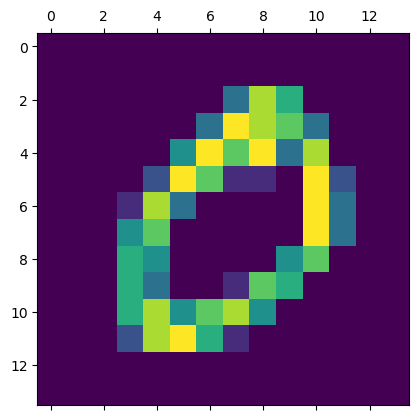

In [63]:
#________ Sample example: ___________
index=0
digit_image = train[index][0]

image = digit_image.reshape(14, -1)

print("Sample targets are One-Hot Encoded vectors (0-9): ",'\n', train[index][1])

print("Image for digit {}".format(list(train[index][1]).index(1)))
plt.matshow(image)
plt.show()

In [ ]:
model = Network([196,98,10])

model.train(new_train,100,0.05,True,new_val)

test_accuracy = model.evaluate(new_test)


Epoch    1: Train acc    0.73149, Test acc    0.71100
Epoch   10: Train acc    0.91928, Test acc    0.86900
Epoch   20: Train acc    0.95397, Test acc    0.88000
Epoch   30: Train acc    0.96965, Test acc    0.89800
Epoch   40: Train acc    0.97999, Test acc    0.89900


In [52]:
print("Accuracy on test-set: ", test_accuracy)

0.903
